# Prédiction de l'action du joueur de Tennis

**Lire les donées**

In [84]:
# Lecture des données

import numpy as np
import PIL
from PIL import Image 

data_size = 2
frame_size = 30
X = []
for i in range(data_size): # chaque vidéo est une données
    D = []
    for j in range(frame_size): # chaque frame est une variable, 720*1280 * 42
        img = PIL.Image.open(f"F:/Tennis/video_shadow_{i}/frame_{j}.jpg").convert("L")
        imgarr = np.array(img)
        img_row = imgarr.reshape(-1) # transformer en ligne
        D = np.append(D, img_row)
    # print(D)
    X.append(D)
print(X, X[0].shape)
print(type(X), type(X[0]), type(X[0][0]))

[array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])] (866730,)
<class 'list'> <class 'numpy.ndarray'> <class 'numpy.float64'>


In [58]:
# Label de la sortie
# 0 : sv j1
# 1 : sv j2
# 2 : cd j1
# 3 : cd j2
# y = []
# for i in range(data_size):
#    y[i] = 0
y = [2, 0]

**K-means**

In [69]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(x, y, c=kmeans.labels_)
plt.show()

NameError: name 'data' is not defined

**Réseaux de neurones**

In [59]:
# Construction du model avec tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

model = Sequential(
    [               
        tf.keras.Input(shape = 866730),
        Dense(units=5, activation="sigmoid"),
        Dense(units=15, activation="sigmoid"),
        Dense(units=1, activation="sigmoid"),
    ], name = "TennisAction" 
)          
model.summary()


Model: "TennisAction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 5)                 4333655   
                                                                 
 dense_19 (Dense)            (None, 15)                90        
                                                                 
 dense_20 (Dense)            (None, 1)                 16        
                                                                 
Total params: 4,333,761
Trainable params: 4,333,761
Non-trainable params: 0
_________________________________________________________________


In [88]:
X_train = np.array(X, dtype = object)
y_train = np.array(y, dtype = object)
print(X_train.shape, type(X_train))
print(X_train[1].shape, type(X_train[1]))
print(X_train[1][0].shape, type(X_train[1][0]))
print(X_train, X_train[0], X_train[0][0])
print(y_train.shape, type(y_train), type(y_train[1]))
print(y_train, y_train[0])

(2,) <class 'numpy.ndarray'>
(1344000,) <class 'numpy.ndarray'>
() <class 'numpy.float64'>
[array([0., 0., 0., ..., 0., 0., 0.]) array([0., 0., 0., ..., 0., 0., 0.])] [0. 0. 0. ... 0. 0. 0.] 0.0
(2,) <class 'numpy.ndarray'> <class 'int'>
[2 0] 2


In [80]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    X_train, y_train,
    epochs = 40, # itération
    # batch_size = 32 # données transmises pour une session
)

prediction = model.predict(np.asarray(X[0], dtype = object))
prediction_p = tf.nn.softmax(prediction)
yhat = np.argmax(prediction_p)

# Softmax
def softmax(z):  
    ez = np.exp(z)
    a = ez/np.sum(ez)
    return a # vecteur vers la probabilité


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [54]:
# Modèle général pour tester les paramètres
def neural_network(num_layer, units, learning_rate=0.001):
    """
    Parameters
    ----------
    num_layer       : int
                    number of layers
    units           : list
                    number of units in each layer
    learning_rate   : float
                    learning rate of the optimizer of the model
    """
    if (len(units) != num_layer):
        raise ValueError("Number of list of units must be equal to number of layers")
    model = Sequential()
    model.add(Dense(units=units[0], input_dim=X_train.shape[1], activation="relu"))
    for i in range(1, num_layer-1):
        model.add(Dense(units=units[i], activation="relu"))
    model.add(Dense(units=1, activation="linear"))
    model.compile(
        loss=tf.keras.losses.MeanAbsoluteError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

In [55]:
# Evaluation des modèle
histories_neural_network = []
def neural_network_score(num_layer, units, learning_rate=[0.001, 0.01, 0.1]):
    """
    Parameters
    ----------
    num_layer       : int
                    number of layers
    units           : list
                    number of units in each layer
    learning_rate   : list
                    learning rate of the optimizer of the model
    """
    if (len(units) != num_layer):
        raise ValueError('Le nombre de couches doit être égale à la taille de la liste des neurones')
    for i in range(len(learning_rate)):
        model = neural_network(num_layer, units, learning_rate=learning_rate[i])
        model.save(f"neural_network_model_{i}.h5")
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=50,
            validation_split=0.2
        )
        histories_neural_network.append(history)
        y_pred = model.predict(X_test)
        y_pred = np.reshape(y_pred, (y_pred.shape[0],))
        print(f'TEST - R2 score avec le taux {learning_rate[i]} : {r2_score(y_test_numpy, y_pred)}')
        print(f'TEST - MAE score avec le taux {learning_rate[i]} : {history.history["val_loss"][-1]}')

In [56]:
# Entraînement des différents modèles
num_layer = 4
units = [128, 256, 256, 1]
neural_network_score(num_layer, units)

Epoch 1/50
277/277 [==============================] - 3s 5ms/step - loss: 411623.5000 - mean_absolute_error: 411623.5000 - val_loss: 183748.5938 - val_mean_absolute_error: 183748.5938
Epoch 2/50
277/277 [==============================] - 1s 4ms/step - loss: 147840.0781 - mean_absolute_error: 147840.0781 - val_loss: 121054.4844 - val_mean_absolute_error: 121054.4844
Epoch 3/50
277/277 [==============================] - 1s 4ms/step - loss: 118232.6875 - mean_absolute_error: 118232.6875 - val_loss: 110318.7031 - val_mean_absolute_error: 110318.7031
Epoch 4/50
277/277 [==============================] - 1s 4ms/step - loss: 112066.8984 - mean_absolute_error: 112066.8984 - val_loss: 106881.0391 - val_mean_absolute_error: 106881.0156
Epoch 5/50
277/277 [==============================] - 1s 4ms/step - loss: 109539.2109 - mean_absolute_error: 109539.2109 - val_loss: 104900.7578 - val_mean_absolute_error: 104900.7578
Epoch 6/50
277/277 [==============================] - 1s 4ms/step - loss: 108031

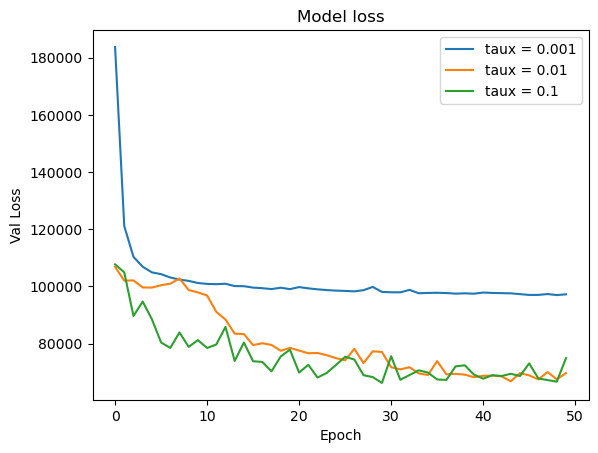

In [57]:
#Visualiser les traces
from sklearn.metrics import r2_score
plt.plot(histories_neural_network[0].history['val_loss'])
plt.plot(histories_neural_network[1].history['val_loss'])
plt.plot(histories_neural_network[2].history['val_loss'])
plt.title('Model loss')  
plt.ylabel('Val Loss')  
plt.xlabel('Epoch')  
plt.legend(['taux = 0.001', 'taux = 0.01', 'taux = 0.1'], loc='upper right')  
plt.show()

136/136 [==============================] - 0s 2ms/step
TEST - R2 score - Réseau de neurones:  0.8960400145485914


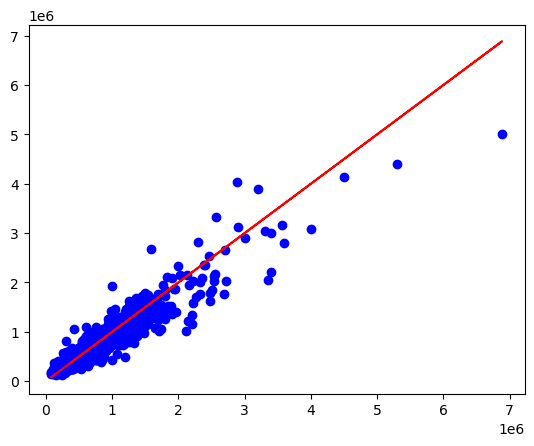

In [58]:
# Test de la performance
#from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
#from math import sqrt
X_test_numpy = np.array(X_test)
y_test_numpy = np.array(y_test)
y_pred = model.predict(X_test_numpy)
y_pred = np.reshape(y_pred, (y_pred.shape[0],))
plt.scatter(y_test, y_pred, color="b")
plt.plot(y_test, y_test, color="r")
r2_nn = r2_score(y_test_numpy, y_pred)
print('TEST - R2 score - Réseau de neurones: ', r2_nn)